# --- Motion Classification Rehab --- 

### 1. IMPORTS & SETUP

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [3]:
# Sklearn Preprocessing & Metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [4]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [5]:
# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries Imported Successfully")

✅ Libraries Imported Successfully


###  Data Loading and Inspection



> Load the MPU dataset and display basic information to understand the structure and data types, as well as summary statistics to get an overview of the data.



In [6]:
df = pd.read_excel("D:\الكليه\Project 3\Motion-Correctness-Classification\data\mpuData.xlsx")

In [7]:
df.head()

,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ
0,Stretching,True,1,Shoulder,-0.25,-0.01,-0.02,0.01,9.78
1,Stretching,True,1,Elbow,0.91,-0.17,-0.03,0.00,9.77
2,Stretching,True,1,Wrist,0.57,-0.12,-0.02,0.03,9.75
3,Stretching,True,1,Hand,0.71,-0.11,-0.04,0.05,9.72
4,Stretching,True,1,Shoulder,0.25,-0.07,-0.02,0.02,9.77


In [8]:
df.tail()

,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ
191,Stretching,False,0,Hand,0.74,3.02,0.52,-0.10,10.42
192,Stretching,False,0,Shoulder,-0.80,0.95,0.26,-0.26,9.91
193,Stretching,False,0,Elbow,0.12,3.24,0.82,0.11,10.27
194,Stretching,False,0,Wrist,-0.13,4.38,0.95,-0.19,10.48
195,Stretching,False,0,Hand,0.59,3.15,0.50,-0.13,10.40


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Movement_Name   196 non-null    object 
 1   Movement_Label  196 non-null    bool   
 2   Label_Value     196 non-null    int64  
 3   Joint_Label     196 non-null    object 
 4   Pitch           196 non-null    float64
 5   Roll            196 non-null    float64
 6   AccelX          196 non-null    float64
 7   AccelY          196 non-null    float64
 8   AccelZ          196 non-null    float64
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 12.6+ KB


### Descriptive statistics

In [10]:
df.describe()

,Label_Value,Pitch,Roll,AccelX,AccelY,AccelZ
count,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,0.489796,-0.261327,2.291327,0.730255,-0.100408,10.104184
std,0.501176,0.867205,1.888887,0.539372,0.205964,0.383193
min,0.000000,-2.240000,-1.610000,-1.000000,-0.570000,8.940000
25%,0.000000,-0.757500,0.780000,0.317500,-0.220000,9.852500
50%,0.000000,-0.235000,2.040000,0.800000,-0.105000,10.240000
75%,1.000000,0.160000,3.460000,1.082500,0.020000,10.392500
max,1.000000,3.350000,7.740000,1.830000,0.510000,10.590000


### Class balance check

In [11]:
df['Movement_Label'].value_counts()

Movement_Label
False    100
True      96
Name: count, dtype: int64

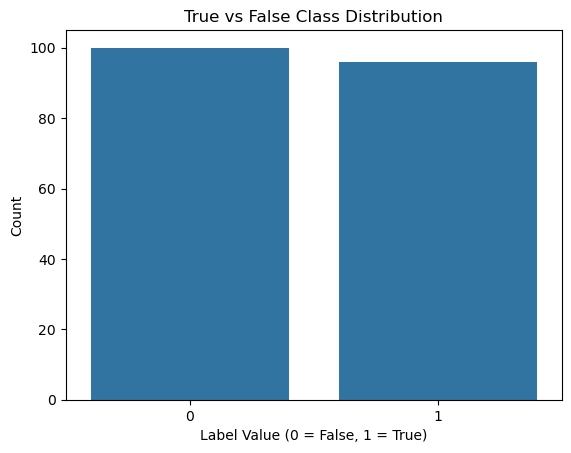

In [12]:
sns.countplot(x="Label_Value", data=df)
plt.title("True vs False Class Distribution")
plt.xlabel("Label Value (0 = False, 1 = True)")
plt.ylabel("Count")
plt.show()

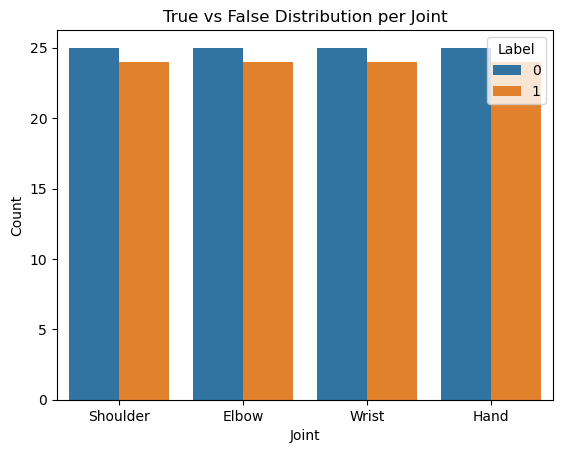

In [13]:
sns.countplot(
    x="Joint_Label",
    hue="Label_Value",
    data=df
)
plt.title("True vs False Distribution per Joint")
plt.xlabel("Joint")
plt.ylabel("Count")
plt.legend(title="Label")
plt.show()


### Feature Engineering on RAW Data 
> Logic: Calculate physics-based features BEFORE aggregation to capture intensity.

In [14]:
# 1. Calculate Acceleration Magnitude (Total Force)
df['Accel_Mag'] = np.sqrt(df['AccelX']**2 + df['AccelY']**2 + df['AccelZ']**2)

# 2. Calculate Angle Difference (Pitch vs Roll interaction)
df['Angle_Diff'] = np.abs(df['Pitch'] - df['Roll'])

print(f"✅ Feature Engineering Complete. Data Shape: {df.shape}")
df.head()

✅ Feature Engineering Complete. Data Shape: (196, 11)


,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ,Accel_Mag,Angle_Diff
0,Stretching,True,1,Shoulder,-0.25,-0.01,-0.02,0.01,9.78,9.780026,0.24
1,Stretching,True,1,Elbow,0.91,-0.17,-0.03,0.00,9.77,9.770046,1.08
2,Stretching,True,1,Wrist,0.57,-0.12,-0.02,0.03,9.75,9.750067,0.69
3,Stretching,True,1,Hand,0.71,-0.11,-0.04,0.05,9.72,9.720211,0.82
4,Stretching,True,1,Shoulder,0.25,-0.07,-0.02,0.02,9.77,9.770041,0.32


### 3. STATISTICAL AGGREGATION (The Core Step)

> Logic: We condense time-series data into a single summary row per exercise repetition.

> We use Mean (for general position) and Std (for stability/shakiness).

In [15]:
joint_agg = df.groupby(['Movement_Name', 'Joint_Label', 'Label_Value']).agg({
    'AccelX': ['mean', 'std'],
    'AccelY': ['mean', 'std'],
    'AccelZ': ['mean', 'std'],
    'Pitch':  ['mean', 'std'],
    'Roll':   ['mean', 'std'],
    'Accel_Mag': ['mean', 'std'],
    'Angle_Diff': ['mean', 'std']
}).reset_index()

# Flatten hierarchical column names (e.g., AccelX_mean, AccelX_std)
joint_agg.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in joint_agg.columns]

# Rename Target Column
joint_agg.rename(columns={'Label_Value': 'Target'}, inplace=True)

# Handle potential NaNs (if a group has only 1 row, std becomes NaN -> replace with 0)
joint_agg.fillna(0, inplace=True)

print(f"✅ Data Aggregated. New Shape: {joint_agg.shape}")
# Note: Expect small shape (e.g., 16 rows) if data is limited.

✅ Data Aggregated. New Shape: (16, 17)


### 4. PREPROCESSING (Encoding, Splitting, Scaling)

In [16]:
# A. One-Hot Encoding for 'Joint_Label'
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
joint_encoded = encoder.fit_transform(joint_agg[['Joint_Label']])
joint_encoded_df = pd.DataFrame(joint_encoded, columns=encoder.get_feature_names_out(['Joint_Label']))

# B. Construct Final Feature Matrix (X) and Target Vector (y)
# Drop non-numeric and target columns
features_to_drop = ['Movement_Name', 'Joint_Label', 'Target']
X = pd.concat([joint_agg.drop(features_to_drop, axis=1), joint_encoded_df], axis=1)
y = joint_agg['Target']

# C. Train-Test Split
# Stratify is crucial here to ensure both classes (0 and 1) are in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# D. Feature Scaling (StandardScaler)
# CRITICAL: Fit on X_train ONLY, then transform X_test. Prevents Data Leakage.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data Split and Scaled.")
print(f"   Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

✅ Data Split and Scaled.
   Train Shape: (12, 18), Test Shape: (4, 18)


###  5. MODEL DEFINITION & TRAINING (Optimized for Small Data)

In [17]:
# Dictionary of models with HYPERPARAMETERS TUNED for small datasets
models_dict = {
    # Logistic Regression: Linear, stable, simple.
    "Logistic Regression": LogisticRegression(
        random_state=42, 
        solver='liblinear' # Better for small datasets
    ),
    
    # Random Forest: Limited depth to prevent memorizing the 12 training rows.
    "Random Forest": RandomForestClassifier(
        n_estimators=50,   # Reduced from 100
        max_depth=3,       # Very shallow trees
        min_samples_split=4,
        random_state=42
    ),
    
    # XGBoost: Conservative learning rate and depth.
    "XGBoost": XGBClassifier(
        n_estimators=30,
        max_depth=2,       # Prevent overfitting
        learning_rate=0.1,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ),
    
    # AdaBoost: Boosting with a simpler base.
    "AdaBoost": AdaBoostClassifier(
        n_estimators=30,
        learning_rate=0.5, # Slightly aggressive to find patterns
        random_state=42
    )
}

# Storage for results
results = []
trained_models = {}

print("\n🚀 Starting Model Training & Evaluation...\n")

for name, model in models_dict.items():
    # 1. Train the model
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    
    # 2. Evaluate on Test Set
    y_pred = model.predict(X_test_scaled)
    test_acc = model.score(X_test_scaled, y_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # 3. Cross-Validation (The most important metric for small data)
    # 5-Fold CV on the training set
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=StratifiedKFold(n_splits=3), scoring='accuracy')
    avg_cv_acc = cv_scores.mean()
    
    # Store metrics
    results.append({
        "Model Name": name,
        "Test Accuracy": test_acc,
        "CV Accuracy (Mean)": avg_cv_acc,
        "F1 Score": f1
    })
    
    print(f"🔹 {name} -> Test Acc: {test_acc:.2f} | CV Acc: {avg_cv_acc:.2f}")

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results)
print("\n📊 Final Performance Summary:")
print(results_df.sort_values(by="CV Accuracy (Mean)", ascending=False))


🚀 Starting Model Training & Evaluation...



🔹 Logistic Regression -> Test Acc: 1.00 | CV Acc: 0.50
🔹 Random Forest -> Test Acc: 0.75 | CV Acc: 0.25
🔹 XGBoost -> Test Acc: 0.50 | CV Acc: 0.75
🔹 AdaBoost -> Test Acc: 0.75 | CV Acc: 0.42

📊 Final Performance Summary:
            Model Name  Test Accuracy  CV Accuracy (Mean)  F1 Score
2              XGBoost           0.50            0.750000  0.333333
0  Logistic Regression           1.00            0.500000  1.000000
3             AdaBoost           0.75            0.416667  0.733333
1        Random Forest           0.75            0.250000  0.733333


### 6. VISUALIZATION (Confusion Matrix for Best Model)


🏆 Best Model Selected: XGBoost


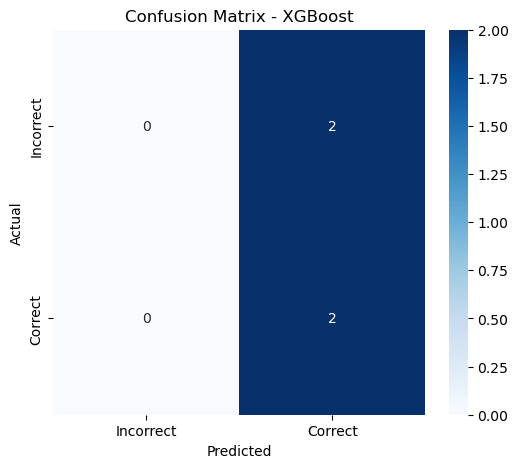

In [18]:
# Select best model based on CV Accuracy (more reliable than Test Acc here)
best_model_name = results_df.sort_values(by="CV Accuracy (Mean)", ascending=False).iloc[0]["Model Name"]
best_model = trained_models[best_model_name]

print(f"\n🏆 Best Model Selected: {best_model_name}")

# Generate Confusion Matrix
y_pred_final = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Incorrect', 'Correct'], 
            yticklabels=['Incorrect', 'Correct'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

### 7. EXPORT MODEL & SCALER

In [19]:
# Setup directory
if not os.path.exists('models'):
    os.makedirs('models')
    print("📁 Created 'models' directory")

model_path = 'models/final_motion_classifier.joblib'
scaler_path = 'models/motion_scaler.joblib'

# Save the Best Model and the Scaler used for training
joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)

print(f"✅ Saved Best Model to: {model_path}")
print(f"✅ Saved Scaler to: {scaler_path}")
print("\n🎉 Pipeline Finished Successfully.")

📁 Created 'models' directory
✅ Saved Best Model to: models/final_motion_classifier.joblib
✅ Saved Scaler to: models/motion_scaler.joblib

🎉 Pipeline Finished Successfully.


In [20]:
df

,Movement_Name,Movement_Label,Label_Value,Joint_Label,Pitch,Roll,AccelX,AccelY,AccelZ,Accel_Mag,Angle_Diff
0,Stretching,True,1,Shoulder,-0.25,-0.01,-0.02,0.01,9.78,9.780026,0.24
1,Stretching,True,1,Elbow,0.91,-0.17,-0.03,0.00,9.77,9.770046,1.08
2,Stretching,True,1,Wrist,0.57,-0.12,-0.02,0.03,9.75,9.750067,0.69
3,Stretching,True,1,Hand,0.71,-0.11,-0.04,0.05,9.72,9.720211,0.82
4,Stretching,True,1,Shoulder,0.25,-0.07,-0.02,0.02,9.77,9.770041,0.32
...,...,...,...,...,...,...,...,...,...,...,...
191,Stretching,False,0,Hand,0.74,3.02,0.52,-0.10,10.42,10.433446,2.28
192,Stretching,False,0,Shoulder,-0.80,0.95,0.26,-0.26,9.91,9.916819,1.75
193,Stretching,False,0,Elbow,0.12,3.24,0.82,0.11,10.27,10.303271,3.12
194,Stretching,False,0,Wrist,-0.13,4.38,0.95,-0.19,10.48,10.524685,4.51
